In [2]:
from qutip import *
import numpy as np
from scipy import constants
import datetime
import time
import gc
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
from numpy.linalg import inv
from numpy import linalg as LA
from scipy.optimize import minimize_scalar
import math
from scipy.optimize import curve_fit
from scipy.sparse.linalg import eigs

In [4]:
plt.rcParams.update({'font.size': 8})

In [6]:
#                       |e> 
#                    --------
#                    /     \
#  Δg, Ωg (probe!)  /       \  Δr, Ωr
#                  /         \ 
#                 /        -------
#             -------        |r> 
#               |g> 

In [7]:
#basis {e,r,g}
N = 3
e = basis(N,0)
r = basis(N,1)
g = basis(N,2)

## Absorption profile of rest ion

In [8]:
def pope(Gamma, Deltar, Omegag, Omegar, Deltag_min, Deltag_max, nn):
    #rhos = []
    pop_e = []
    #tstart = time.time();

    #c1 = sqrt(Gamma/3)*p*e.dag()
    c2 = np.sqrt(Gamma/2)*r*e.dag()
    c3 = np.sqrt(Gamma/2)*g*e.dag()

    #linbland operator/collapse operators
    c = [c2,c3]
    #c = [c3]
    c_ops =[spre(c[i])*spost(c[i].dag()) - 0.5*(spre(c[i].dag()*c[i]) + spost(c[i].dag()*c[i])) for i in range(N-1)]

    for Deltag in tqdm(np.linspace(Deltag_min,Deltag_max,nn)):

        #Hamiltonian for a rest ion
        H1 = Deltag*g*g.dag() + Deltar*r*r.dag()
        H2 = -0.5*(Omegag*e*g.dag() + Omegar*e*r.dag() + Omegag*g*e.dag() + Omegar*r*e.dag())
        H = H1 + H2
        

        rho = steadystate(H,c)

        #rhos.append(rho)
    
        pop_e.append(expect(e*e.dag(),rho))
        #print(i)
    
    #print('running time = '+str(time.time()-tstart)+' seconds')
    
    return pop_e#,rhos

## Fictitious lasers

In [9]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [10]:
def steck(Gamma, Deltar, Deltag, Omegar, Omegag,Delta,eta): #fictitious lasers method

    H1 = Deltag*g*g.dag() + Deltar*r*r.dag()
    H2 = -0.5*(Omegag*e*g.dag() + Omegar*e*r.dag() + Omegag*g*e.dag() + Omegar*r*e.dag())
    H0 = H1 + H2

    c2 = np.sqrt(Gamma/2)*r*e.dag()
    c3 = np.sqrt(Gamma/2)*g*e.dag()

    c = [c2,c3]

    rho0 = steadystate(H0,c)

    L0 = 0*spre(c[0])*spost(c[0].dag())
    for i in range(len(c)):
        L0 += spre(c[i])*spost(c[i].dag()) - 0.5*(spre(c[i].dag()*c[i]) + spost(c[i].dag()*c[i]))

    L0 += -1j*(spre(H0) - spost(H0))

    #L0 = np.array(L0)
    L0 = L0.data_as('ndarray')


    Ht = -0.5*(eta*Omegag*g*e.dag() - eta*Omegar*r*e.dag())
    L1 = -1j*(spre(Ht) - spost(Ht))

    #L1 = np.array(L1)
    L1 = L1.data_as('ndarray')

    #Ht1 = 0.5*(1j*eta*Omegag*e*g.dag() -1j*eta*Omegar*e*r.dag())
    Ht1 = Ht.dag()
    L_1 = -1j*(spre(Ht1) - spost(Ht1))

    #L_1 = np.array(L_1)
    L_1 = L_1.data_as('ndarray')




    #S3 = -np.matmul(inv(L0-3j*Delta*np.eye(N**2)),L1)
    #S2 = -np.matmul(inv(L0-2j*Delta*np.eye(N**2)+ np.matmul(L_1,S3)),L1)
    S2 = -np.matmul(inv(L0-2j*Delta*np.eye(N**2)),L1)
    S1 = -np.matmul(inv(L0-1j*Delta*np.eye(N**2) + np.matmul(L_1,S2)),L1) 
    #S1 = -np.matmul(inv(L0-1j*Delta*np.eye(N**2)),L1) 

    #T_3 = -np.matmul(inv(L0+3j*Delta*np.eye(N**2)),L_1)
    #T_2 = -np.matmul(inv(L0+2j*Delta*np.eye(N**2)+ np.matmul(L1,T_3)),L_1)
    T_2 = -np.matmul(inv(L0+2j*Delta*np.eye(N**2)),L_1)
    T_1 = -np.matmul(inv(L0+1j*Delta*np.eye(N**2)+ np.matmul(L1,T_2)),L_1)
    #T_1 = -np.matmul(inv(L0+1j*Delta*np.eye(N**2)),L_1)
    
    L = np.matmul(L_1,S1) + L0 +np.matmul(L1,T_1)
    
    eigenvalues, eigenvectors = LA.eig(L)

    idx = find_nearest(eigenvalues, 0+0j)
    rhoss = eigenvectors[:,idx]

    rhos = np.zeros((N,N),dtype='complex64')
    for i in range(N):
        for j in range(N):
            rhos[j,i] = rhoss[j+i*N]

    rho = Qobj(rhos)
    if rho.tr() != 0:
        rho = rho/rho.tr()

    rho_ = operator_to_vector(rho)
    #rho_ = np.array(rho_)
    rho_ = rho_.data_as('ndarray')

    rho1 = np.matmul(S1,rho_)
    #rho2 = np.matmul(S2,rho_)
    #rho3 = np.matmul(S3,rho_)

    rho_1 = np.matmul(T_1,rho_)
    #rho_2 = np.matmul(T_2,rho_)
    #rho_3 = np.matmul(T_3,rho_)

    rhos1 = np.zeros((N,N),dtype='complex64')
    #rhos2 = np.zeros((N,N),dtype='complex64')
    #rhos3 = np.zeros((N,N),dtype='complex64')
    rhos_1 = np.zeros((N,N),dtype='complex64')
    #rhos_2 = np.zeros((N,N),dtype='complex64')
    #rhos_3 = np.zeros((N,N),dtype='complex64')
    for i in range(N):
        for j in range(N):
            rhos1[j,i] = rho1[j+i*N]
            #rhos2[j,i] = rho2[j+i*N]
            #rhos3[j,i] = rho3[j+i*N]
            rhos_1[j,i] = rho_1[j+i*N]
            #rhos_2[j,i] = rho_2[j+i*N]
            #rhos_3[j,i] = rho_3[j+i*N]
            
    Rho1 = Qobj(rhos1)
    #Rho2 = Qobj(rhos2)
    #Rho3 = Qobj(rhos3)
    Rho_1 = Qobj(rhos_1)
    #Rho_2 = Qobj(rhos_2)
    #Rho_3 = Qobj(rhos_3)
       

    return -1j*2*np.pi*(eta*Omegag/2*expect(g*e.dag(),Rho_1)  \
                            -eta*Omegar/2*expect(r*e.dag(),Rho_1)   \
                            -eta*Omegag/2*(expect(e*g.dag(),Rho1) ) \
                            +eta*Omegar/2*(expect(e*r.dag(),Rho1)  ))

## Fluctuation Spectrum

In [11]:
def S_(Gamma, Deltar, Deltag, Omegar, Omegag,omega,eta):

     #Gamma=2*np.pi*Gamma
    H1 = 2*pi*(Deltag*g*g.dag() + Deltar*r*r.dag())
    H2 = -pi*(Omegag*e*g.dag() + Omegar*e*r.dag() + Omegag*g*e.dag() + Omegar*r*e.dag())
    H0 = H1 + H2

    c2 = np.sqrt(Gamma*2*pi/2)*r*e.dag()
    c3 = np.sqrt(2*pi*Gamma/2)*g*e.dag()

    c = [c2,c3]
    rho = steadystate(H0,c) #!

    L0 = 0*spre(c[0])*spost(c[0].dag())
    for i in range(len(c)):
        L0 += spre(c[i])*spost(c[i].dag()) - 0.5*(spre(c[i].dag()*c[i]) + spost(c[i].dag()*c[i]))

    L0 += -1j*(spre(H0) - spost(H0))
    
    #L0 = np.array(L0)
    L0 = L0.data_as('ndarray')

    V1 = pi*(-eta*Omegag*e*g.dag() + eta*Omegar*e*r.dag())
    V1 = V1 + V1.dag()
    V1rho = V1*rho

    V1rho = operator_to_vector(V1rho)
    #V1rho = np.array(V1rho)
    V1rho = V1rho.data_as('ndarray')

    eye = np.eye(N**2)
    inve = -inv((L0+1j*2*pi*omega*eye))

    s = inve@V1rho

    S = np.zeros((N,N),dtype=np.complex_)
    for i in range(N):
        for j in range(N):
            S[j,i] = s[N*i+j][0]
            
    #V1 = np.array(V1)
    V1 =V1.data_as('ndarray')
    S = np.matmul(V1,S)

    return np.matrix.trace(S)

In [12]:
#parameters G.Morigi PRL (MHz)
Gamma = 20
Omegar = 17
Omegag = Omegar
Deltar = 70
Deltag = Deltar
omega = Gamma/10
eta = 0.01

In [13]:
Gammas = np.concatenate((np.arange(2.5,12.5,2.5),np.arange(15.,55.,5.)))

In [14]:
Gammas = np.concatenate((np.array([1]),Gammas))

In [15]:
wfic = np.zeros(len(Gammas),dtype='complex')
w = np.zeros(len(Gammas),dtype='complex')

for i in range(len(Gammas)):
    
    wfic[i] = steck(Gammas[i], Deltar, Deltag, Omegar,Omegar, omega, eta) - steck(Gammas[i], Deltar, Deltag, Omegar, Omegar, -omega, eta)

    w[i] = 2*S_(Gammas[i], Deltar, Deltag, Omegar, Omegar,omega,eta) - 2*S_(Gammas[i], Deltar, Deltag, Omegar, Omegar,-omega,eta)

C:\Users\kfouka\AppData\Local\Temp\ipykernel_20476\3096020492.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos1[j,i] = rho1[j+i*N]
C:\Users\kfouka\AppData\Local\Temp\ipykernel_20476\3096020492.py:91: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos_1[j,i] = rho_1[j+i*N]


C:\Users\kfouka\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\kfouka\AppData\Local\anaconda3\Lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


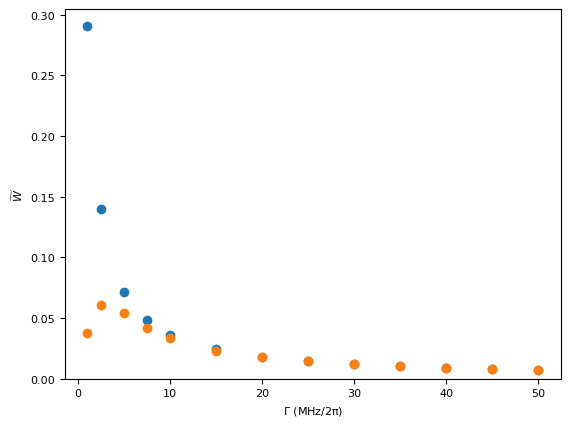

In [16]:
plt.figure()
#plt.title('W_{exp}')
plt.scatter(Gammas,w.real)
plt.scatter(Gammas,wfic)
#plt.xlim(0,5000)
#plt.legend()
plt.ylabel('$\widetilde{W}$')
plt.xlabel('$Γ$ (ΜΗz/2π)')
plt.ylim(0)
#plt.xlim(0)
#plt.savefig("I1_eta_Wtilde.png",bbox_inches = "tight")


plt.show()

In [17]:
Gammas[5]

15.0

In [18]:
wfic[5]

(0.02323798673073671+0j)

In [19]:
w[5]

(0.024115297126103816-0.0020971695893594253j)

## Cooling

In [21]:
t = []
n = []
for gamma in Gammas:
    t.append(np.loadtxt(""+str(path_name)+"cooling_EIT_Omegap_17_Omegar_17_Delta_70_Gamma_"+str(gamma)+"_eta_0.01_gs.txt")[:, 0])
    n.append(np.loadtxt(""+str(path_name)+"cooling_EIT_Omegap_17_Omegar_17_Delta_70_Gamma_"+str(gamma)+"_eta_0.01_gs.txt")[:, 1])
    

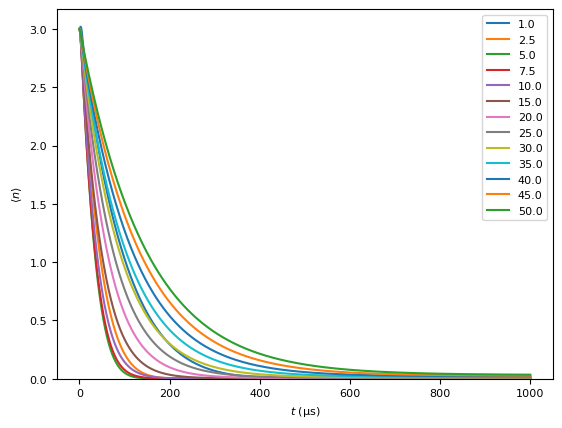

In [22]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
for i,gamma in enumerate(Gammas):
    plt.plot(t[i],n[i],label=Gammas[i])


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)


plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [23]:
def func(t,a,b,c):
    return a*np.exp(-b*t) + c*(1-np.exp(-b*t))

In [24]:
p0 = (3, .001,.001)
wexp = []
for i in range(len(Gammas)):
    popt, pcov = curve_fit(func,t[i],n[i],p0)
    wexp.append(popt[1])

In [25]:
plt.rcParams.update({'font.size':8 })

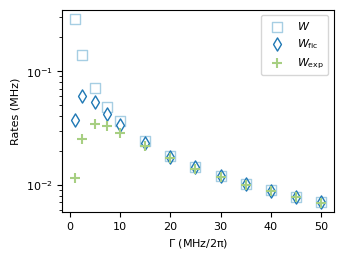

In [26]:
plt.figure(figsize=(3.5,0.75*3.5))
plt.scatter(Gammas,w.real,marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3',s=1.25*plt.rcParams['lines.markersize'] ** 2)
plt.scatter(Gammas,wfic.real,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4',s=1.25*plt.rcParams['lines.markersize'] ** 2)
plt.scatter(Gammas,wexp,marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82',s=1.25*plt.rcParams['lines.markersize'] ** 2)
#plt.xlim(0,5000)
#plt.legend()
plt.ylabel('Rates (MHz)')
plt.xlabel('$Γ$ (ΜΗz/2π)')

plt.yscale('log')
plt.legend(prop={'size': 8})
#plt.xlim(0)
#plt.savefig("I1_eta_Wtilde.png",bbox_inches = "tight")


plt.show()

## Rates - eta

In [29]:
Gammas

array([ 1. ,  2.5,  5. ,  7.5, 10. , 15. , 20. , 25. , 30. , 35. , 40. ,
       45. , 50. ])

In [30]:
etas = np.array([0.01,0.025,0.05,0.075,0.1])

In [31]:
wfic1 = np.zeros(len(etas),dtype='complex')
w1 = np.zeros(len(etas),dtype='complex')

for i in range(len(etas)):
    
    wfic1[i] = steck(Gammas[0], Deltar, Deltag, Omegar,Omegar, omega, etas[i]) - steck(Gammas[i], Deltar, Deltag, Omegar, Omegar, -omega, etas[i])

    w1[i] = 2*S_(Gammas[0], Deltar, Deltag, Omegar, Omegar,omega,etas[i]) - 2*S_(Gammas[i], Deltar, Deltag, Omegar, Omegar,-omega,etas[i])

C:\Users\kfouka\AppData\Local\Temp\ipykernel_20476\3096020492.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos1[j,i] = rho1[j+i*N]
C:\Users\kfouka\AppData\Local\Temp\ipykernel_20476\3096020492.py:91: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos_1[j,i] = rho_1[j+i*N]


In [32]:
t1 = []
n1 = []
for eta in etas:
    t1.append(np.loadtxt(""+str(path_name)+"cooling_EIT_Omegap_17_Omegar_17_Delta_70_Gamma_"+str(Gammas[0])+"_eta_"+str(eta)+"_etas.txt")[:, 0])
    n1.append(np.loadtxt(""+str(path_name)+"cooling_EIT_Omegap_17_Omegar_17_Delta_70_Gamma_"+str(Gammas[0])+"_eta_"+str(eta)+"_etas.txt")[:, 1])
    

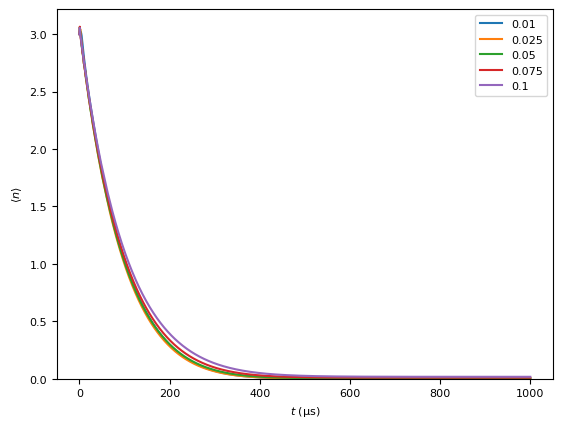

In [33]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
for i,eta in enumerate(etas):
    plt.plot(t1[i],n1[i],label=eta)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)


plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [34]:
t1[0][400]

400.4004004

In [35]:
p0 = (3, .001,.001)
wexp1 = []
for i in range(len(etas)):
    popt, pcov = curve_fit(func,t1[i][:400],n1[i][:400],p0)
    wexp1.append(popt[1])

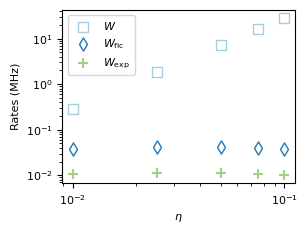

In [36]:
plt.figure(figsize=(3,0.75*3))
plt.scatter(etas,w1.real,marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3',s=1.25*plt.rcParams['lines.markersize'] ** 2)
plt.scatter(etas,wfic1.real,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4',s=1.25*plt.rcParams['lines.markersize'] ** 2)
plt.scatter(etas,np.array(wexp1),marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82',s=1.25*plt.rcParams['lines.markersize'] ** 2)
#plt.xlim(0,5000)
#plt.legend()
plt.ylabel('Rates (MHz)')
plt.xlabel('$η$')

plt.yscale('log')
plt.xscale('log')
plt.legend(prop={'size': 8})
#plt.xlim(0)
#plt.savefig("I1_eta_Wtilde.png",bbox_inches = "tight")


plt.show()

In [37]:
wfic1

array([0.03741068+0.j, 0.04185542+0.j, 0.04199433+0.j, 0.04061316+0.j,
       0.03780991+0.j])

In [38]:
wexp1

[0.010851730715970571,
 0.011087964492501516,
 0.010913230976688013,
 0.010567502407167202,
 0.010091093532823961]

In [39]:
wfic2 = np.zeros(len(etas),dtype='complex')
w2 = np.zeros(len(etas),dtype='complex')

for i in range(len(etas)):
    
    wfic2[i] = steck(Gammas[6], Deltar, Deltag, Omegar,Omegar, omega, etas[i]) - steck(Gammas[i], Deltar, Deltag, Omegar, Omegar, -omega, etas[i])

    w2[i] = 2*S_(Gammas[6], Deltar, Deltag, Omegar, Omegar,omega,etas[i]) - 2*S_(Gammas[i], Deltar, Deltag, Omegar, Omegar,-omega,etas[i])

C:\Users\kfouka\AppData\Local\Temp\ipykernel_20476\3096020492.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos1[j,i] = rho1[j+i*N]
C:\Users\kfouka\AppData\Local\Temp\ipykernel_20476\3096020492.py:91: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos_1[j,i] = rho_1[j+i*N]


In [40]:
t2 = []
n2 = []
for eta in etas:
    t2.append(np.loadtxt(""+str(path_name)+"cooling_EIT_Omegap_17_Omegar_17_Delta_70_Gamma_"+str(Gammas[6])+"_eta_"+str(eta)+"_etas.txt")[:, 0])
    n2.append(np.loadtxt(""+str(path_name)+"cooling_EIT_Omegap_17_Omegar_17_Delta_70_Gamma_"+str(Gammas[6])+"_eta_"+str(eta)+"_etas.txt")[:, 1])
    

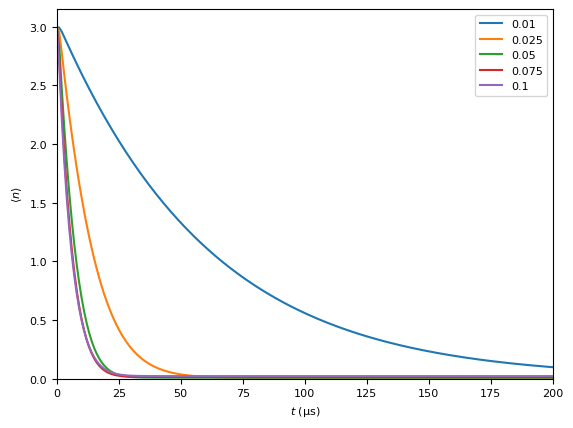

In [41]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
for i,eta in enumerate(etas):
    plt.plot(t2[i],n2[i],label=eta)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
plt.xlim(0,200)


plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [42]:
p0 = (3, .001,.001)
wexp2 = []

popt, pcov = curve_fit(func,t2[0][:200],n2[0][:200],p0)
wexp2.append(popt[1])

In [43]:
popt, pcov = curve_fit(func,t2[1][:50],n2[1][:50],p0)
wexp2.append(popt[1])

In [44]:
for i in range(2,5):
    popt, pcov = curve_fit(func,t2[i][:25],n2[i][:25],p0)
    wexp2.append(popt[1])

In [45]:
Gammas[6]

20.0

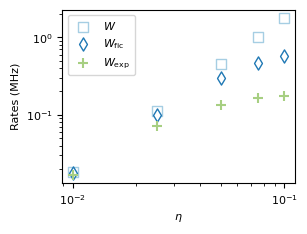

In [46]:
plt.figure(figsize=(3,0.75*3))
plt.scatter(etas,w2.real,marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3',s=1.25*plt.rcParams['lines.markersize'] ** 2)
plt.scatter(etas,wfic2.real,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4',s=1.25*plt.rcParams['lines.markersize'] ** 2)
plt.scatter(etas,wexp2,marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82',s=1.25*plt.rcParams['lines.markersize'] ** 2)
#plt.xlim(0,5000)
#plt.legend()
plt.ylabel('Rates (MHz)')
plt.xlabel('$η$')

plt.yscale('log')
plt.xscale('log')
plt.legend(prop={'size': 8})
#plt.xlim(0)
#plt.savefig("I1_eta_Wtilde.png",bbox_inches = "tight")


plt.show()

In [47]:
wfic3 = np.zeros(len(etas),dtype='complex')
w3 = np.zeros(len(etas),dtype='complex')

for i in range(len(etas)):
    
    wfic3[i] = steck(Gammas[-1], Deltar, Deltag, Omegar,Omegar, omega, etas[i]) - steck(Gammas[i], Deltar, Deltag, Omegar, Omegar, -omega, etas[i])

    w3[i] = 2*S_(Gammas[-1], Deltar, Deltag, Omegar, Omegar,omega,etas[i]) - 2*S_(Gammas[i], Deltar, Deltag, Omegar, Omegar,-omega,etas[i])

C:\Users\kfouka\AppData\Local\Temp\ipykernel_20476\3096020492.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos1[j,i] = rho1[j+i*N]
C:\Users\kfouka\AppData\Local\Temp\ipykernel_20476\3096020492.py:91: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos_1[j,i] = rho_1[j+i*N]


In [48]:
t3 = []
n3 = []
for eta in etas:
    t3.append(np.loadtxt(""+str(path_name)+"cooling_EIT_Omegap_17_Omegar_17_Delta_70_Gamma_"+str(Gammas[-1])+"_eta_"+str(eta)+"_etas.txt")[:, 0])
    n3.append(np.loadtxt(""+str(path_name)+"cooling_EIT_Omegap_17_Omegar_17_Delta_70_Gamma_"+str(Gammas[-1])+"_eta_"+str(eta)+"_etas.txt")[:, 1])
    

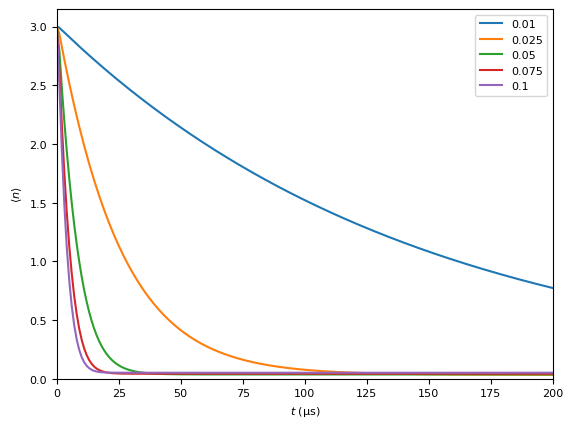

In [49]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
for i,eta in enumerate(etas):
    plt.plot(t3[i],n3[i],label=eta)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
plt.xlim(0,200)


plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [50]:
p0 = (3, .001,.001)
wexp3 = []

popt, pcov = curve_fit(func,t3[0],n3[0],p0)
wexp3.append(popt[1])

In [51]:
popt, pcov = curve_fit(func,t3[1][:100],n3[1][:100],p0)
wexp3.append(popt[1])

In [52]:
for i in range(2,5):
    popt, pcov = curve_fit(func,t3[i][:25],n3[i][:25],p0)
    wexp3.append(popt[1])

In [53]:
Gammas[-1]

50.0

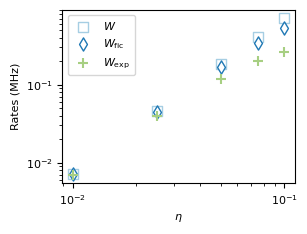

In [54]:
plt.figure(figsize=(3,0.75*3))
plt.scatter(etas,w3.real,marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3',s=1.25*plt.rcParams['lines.markersize'] ** 2)
plt.scatter(etas,wfic3.real,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4',s=1.25*plt.rcParams['lines.markersize'] ** 2)
plt.scatter(etas,wexp3,marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82',s=1.25*plt.rcParams['lines.markersize'] ** 2)
#plt.xlim(0,5000)
#plt.legend()
plt.ylabel('Rates (MHz)')
plt.xlabel('$η$')

plt.yscale('log')
plt.xscale('log')
plt.legend(prop={'size': 8})
#plt.xlim(0)
#plt.savefig("I1_eta_Wtilde.png",bbox_inches = "tight")


plt.show()

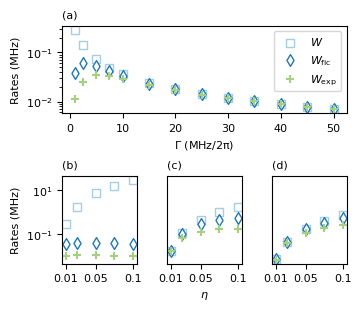

In [110]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rcParams.update({'font.size': 8})
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(constrained_layout=True,figsize=(3.5,3))

gs = GridSpec(2, 3, figure=fig)
gs.update(wspace=0.005, hspace=0.05)
ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))

ax1.set_title(r'(a)',loc='left',fontdict={'fontsize': 8})
ax1.scatter(Gammas,w.real,marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3',s=plt.rcParams['lines.markersize'] ** 2)
ax1.scatter(Gammas,wfic.real,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4',s=plt.rcParams['lines.markersize'] ** 2)
ax1.scatter(Gammas,wexp,marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82',s=plt.rcParams['lines.markersize'] ** 2)
#plt.xlim(0,5000)
#plt.legend()
ax1.set_ylabel('Rates (MHz)')
ax1.set_xlabel('$Γ$ (ΜΗz/2π)')

ax1.set_yscale('log')
ax1.legend(prop={'size': 8})
#plt.xlim(0)
#plt.savefig("I1_eta_Wtilde.png",bbox_inches = "tight")


ax2 = fig.add_subplot(gs[1, 0])
ax2.set_title(r'(b)',loc='left',fontdict={'fontsize': 8})
ax2.scatter(etas,w1.real,marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3',s=plt.rcParams['lines.markersize'] ** 2)
ax2.scatter(etas,wfic1.real,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4',s=plt.rcParams['lines.markersize'] ** 2)
ax2.scatter(etas,np.array(wexp1),marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82',s=plt.rcParams['lines.markersize'] ** 2)
#plt.xlim(0,5000)
#plt.legend()
ax2.set_xlim(0.005,0.105)
ax2.set_xticks([0.01,0.05,0.1])
ax2.set_xticklabels(["0.01","0.05","0.1"])
ax2.set_ylabel('Rates (MHz)')
#ax2.set_xlabel('$η$')

ax2.set_yscale('log')
#ax2.set_xscale('log')
#ax2.legend(prop={'size': 8})

ax3 = fig.add_subplot(gs[1, 1], sharey=ax2)
ax3.set_title(r'(c)',loc='left',fontdict={'fontsize': 8})
ax3.scatter(etas,w2.real,marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3',s=plt.rcParams['lines.markersize'] ** 2)
ax3.scatter(etas,wfic2.real,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4',s=plt.rcParams['lines.markersize'] ** 2)
ax3.scatter(etas,wexp2,marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82',s=plt.rcParams['lines.markersize'] ** 2)
ax3.tick_params(left=False, labelleft=False)
#plt.xlim(0,5000)
#plt.legend()
#ax3.set_ylabel('Rates (MHz)')
ax3.set_xlabel('$η$')
ax3.set_xlim(0.005,0.105)
ax3.set_xticks([0.01,0.05,0.1])
ax3.set_xticklabels(["0.01","0.05","0.1"])

ax3.set_yscale('log')
#ax3.set_xscale('log')
#ax3.legend(prop={'size': 8})



ax4 = fig.add_subplot(gs[1, 2], sharey=ax2)
ax4.set_title(r'(d)',loc='left',fontdict={'fontsize': 8})
ax4.scatter(etas,w3.real,marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3',s=plt.rcParams['lines.markersize'] ** 2)
ax4.scatter(etas,wfic3.real,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4',s=plt.rcParams['lines.markersize'] ** 2)
ax4.scatter(etas,wexp3,marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82',s=plt.rcParams['lines.markersize'] ** 2)
ax4.tick_params(left=False, labelleft=False)
#ax4.set_xlim(0.005,0.105)
#plt.legend()
#ax4.set_ylabel('Rates (MHz)')
#ax4.set_xlabel('$η$')
ax4.set_xlim(0.005,0.105)
ax4.set_xticks([0.01,0.05,0.1])
ax4.set_xticklabels(["0.01","0.05","0.1"])

ax4.set_yscale('log')
#ax4.set_xscale('log')
#ax4.legend(prop={'size': 8})


#plt.xlim(45,55)

#fig.suptitle("GridSpec")
#format_axes(fig)

plt.savefig("eit_rates_Gammas_etas.pdf",bbox_inches = "tight")


plt.show()